In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
%matplotlib inline

In [43]:
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['product_id'] = buy_sessions['product_id'].astype(str)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
df = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
df['product_id'] = df['product_id'].astype(str)

In [44]:
df['date'] = pd.to_datetime(df['date'])

In [45]:
df=df[df['product_id']=='1005']

In [46]:
df=df.groupby(by=[pd.Grouper(key='date', freq='W')]).sum()

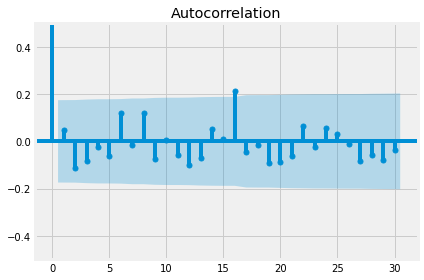

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=30);
plt.ylim([-0.5,0.5])
plt.tight_layout()

In [49]:
df.index=df.index.get_level_values(0)
df.index

DatetimeIndex(['2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25',
               '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06',
               ...
               '2021-10-24', '2021-10-31', '2021-11-07', '2021-11-14',
               '2021-11-21', '2021-11-28', '2021-12-05', '2021-12-12',
               '2021-12-19', '2021-12-26'],
              dtype='datetime64[ns]', name='date', length=126, freq='W-SUN')

In [50]:
train_len=int(0.8*len(df))
train = df[0:train_len]
test = df[train_len:]

In [51]:
sma = df.copy()
ma_window = 2
sma['sma_forecast'] = df['amount'].rolling(ma_window).mean()
sma['sma_forecast'][train_len:] = sma['sma_forecast'][train_len-1]

C:\Users\micha\AppData\Local\Temp/ipykernel_16572/2889514473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['sma_forecast'][train_len:] = sma['sma_forecast'][train_len-1]


In [52]:
y_hat_sma.index=pd.to_datetime(y_hat_sma.index)

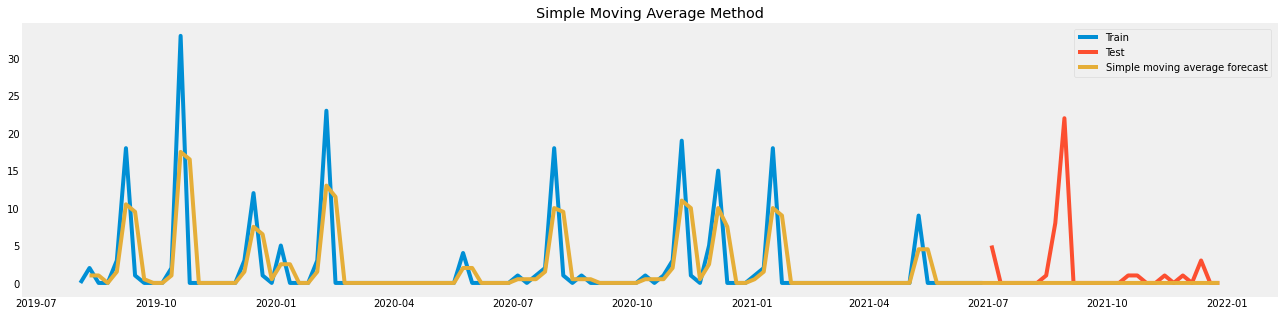

In [41]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['amount'], label='Train')
plt.plot(test['amount'], label='Test')
plt.plot(sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()